# 11. 3D: Segmentation, tracking, visualisation

Until now we have exclusively processed 2D images, even though the sometimes came from 3D acquisition. We are now going to look at an example of 3D processing where we are going to use the same tools as in 2D but in a 3D version.

Extending an image processing pipeline from 2D to 3D can be challenging for two reasons: first, computations can become very slow because of the amount of data changes usually roughly by an order of magnitude (~10s of planes recorded), and second, visualization of both original and processed data is more complicated.

The dataset that we are going to use here is available in full on Zenodo (including license details) at this address: https://zenodo.org/record/1211599#.XqbxjdP7RTb. It's description is the following: "The dataset contains a time-lapse (4D) volumetric fluorescence microscopy image sequence of a living zebrafish embryo (cxcr4aMO). The sequence has been captured with a confocal laser-scanning microscope during zebrafish gastrulation and shows endodermal cells that have been fluorescently labelled." We are here going to see how we can segment the nuclei 3D blobs in this dataset. The dataset being large (2Go), we use here a reduced version of it with only 20 frames. Feel free to download the original dataset from Zenodo to explore it. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.gray()
import skimage.io
import skimage.filters
import skimage.feature

<Figure size 640x480 with 0 Axes>

## 11.1 Segmentation

Let's load the dataset for which we expect 20 time-points and 44 planes:

In [2]:
image_time = skimage.io.imread('../Data/cxcr4aMO2_290112_substack.tif')
image_time.shape

(21, 44, 512, 512)

We see that time is the first dimension and z-stack in the second. Let's just get a first visual impression by looking at projection. We consider $T=20$:

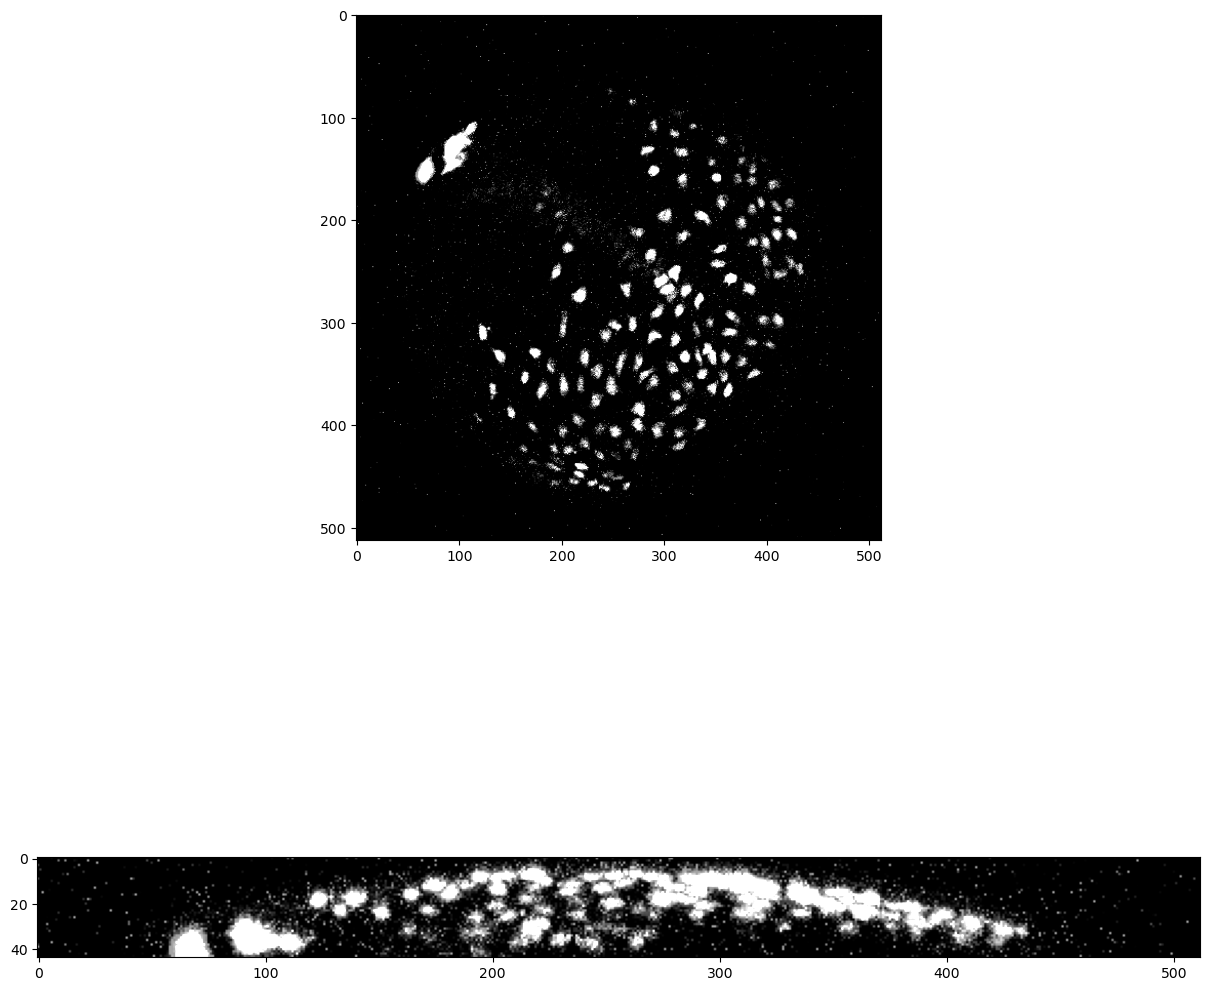

In [3]:
fig, ax = plt.subplots(2,1,figsize = (15,15))
ax[0].imshow(np.max(image_time[0,:,:,:],axis = 0),vmax = 200)
ax[1].imshow(np.max(image_time[0,:,:,:],axis = 1),vmax = 200);

We see that the nuclei are approximately roundish objects. As we have done previously, we can first try to identify their location by doing a Gaussian filtering. Note that we don't have to change anything compared to the 2D version. The $\sigma$ value is assumed to be the same for xyz but we could pass different values if the imaging was more anisotropic:

In [4]:
imG = skimage.filters.gaussian(image_time[0,:,:,:],sigma=2, preserve_range=True)

In [5]:
imG.shape

(44, 512, 512)

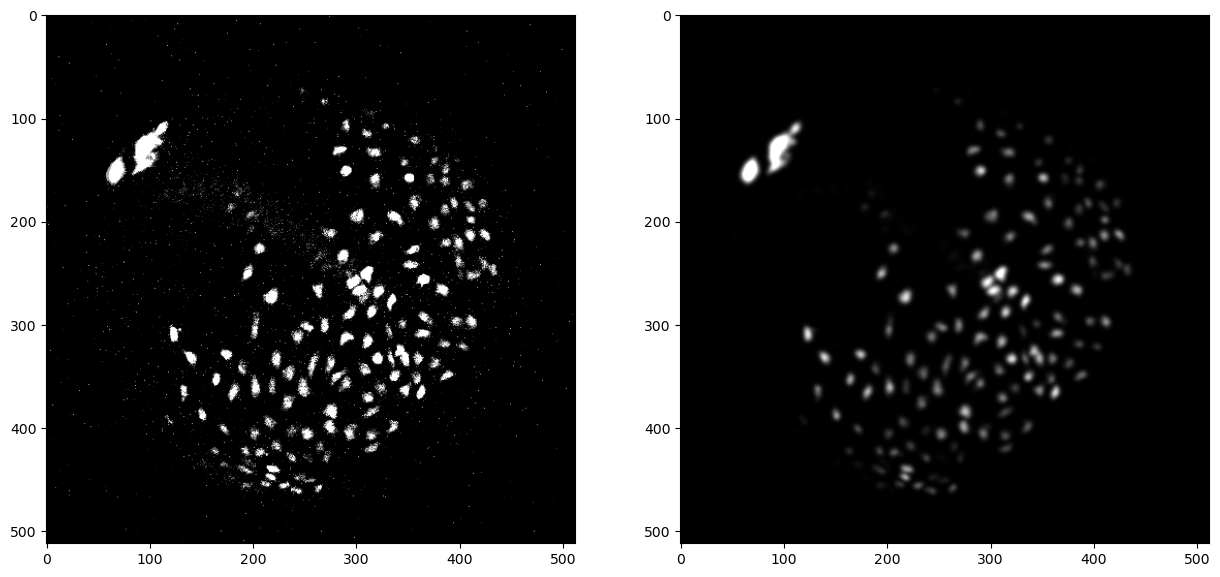

In [6]:
fig, ax = plt.subplots(1,2,figsize = (15,15))
ax[0].imshow(np.max(image_time[0,:,:,:],axis = 0),vmax = 200)
ax[1].imshow(np.max(imG[:,:,:],axis = 0),vmax = 180);

The filtering clearly removed noise in the image and now we should be able to find nuclei locations as local maxima:

In [7]:
locmax = skimage.feature.peak_local_max(imG,min_distance=2, threshold_abs=20)

In [8]:
locmax.shape

(126, 3)

locmax is now a 3D list of coordinates of local maxima. Let's look at the projection: 

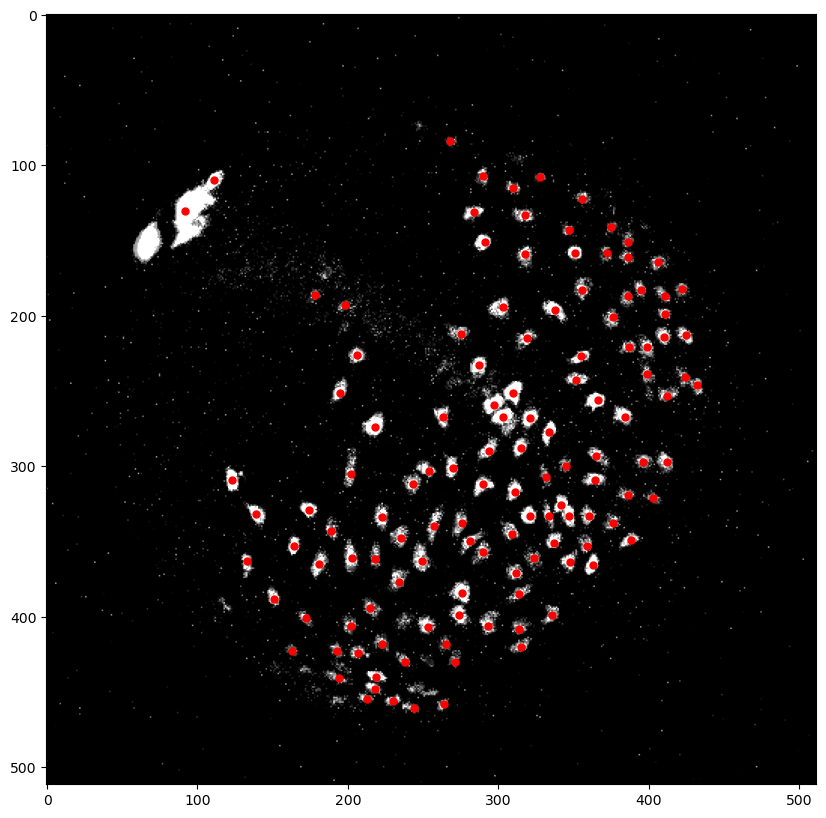

In [9]:
fig, ax = plt.subplots(1,1,figsize = (10,10))
ax.imshow(np.max(image_time[0,:,:,:],axis = 0),vmax = 200)
ax.plot(locmax[:,2], locmax[:,1],'ro', markersize = 5);

It looks like this basic detection worked really well. Note that very often, segmentation is done by a sequential segmentation of 2D planes and then a sort of "tracking" of detected objects across the stack. It is important to understand that a direct 3D detection (if computationally feasible) often performs much better. The reason for this is that information is correlated across planes. The chance that a spurious high intensity pixels would appear across multiple planes is very low, and thus fale-positives are rare. This in particular allows one to work with much weaker signals.

Note that the Machine Learning solutions briefly presented in this course, StarDist and Cellpose, both offer the possibility to perform 3D segmentation. Here again, the syntax doesn not change from 2D. As ML-based 3D processing requires a lot of computing power, these solutions can only be realistically used with a GPU. Please consult the corresponding repository for details on how to install the GPU version of these software.

## 11.3 Tracking

In a previous chapter we have seen how to track objects in 2D using the package trackpy. Just like we naturally extended segmentation from 2D to 3D, we can do the same for tracking. Let's first apply our segmentation to all available time points and store the information in a list:

In [10]:
import pandas as pd
import trackpy

In [11]:
detections = []
for t in range(image_time.shape[0]):
    imG = skimage.filters.gaussian(image_time[t,:,:,:],sigma=2, preserve_range=True)
    locmax = skimage.feature.peak_local_max(imG,min_distance=2, threshold_abs=20)
    
    # add a time column
    locmax = np.concatenate([locmax, t*np.ones((locmax.shape[0],1))],axis = 1)
    detections.append(locmax)

Then we assemble all arrays into a large array and transform it into a Pandas dataframe with appropriate column names:

In [12]:
assembled = np.concatenate(detections)

In [13]:
time_data = pd.DataFrame(assembled, columns=['z','x','y','frame'])

In [14]:
time_data

,z,x,y,frame
0,35.0,130.0,92.0,0.0
1,11.0,251.0,310.0,0.0
2,10.0,267.0,303.0,0.0
3,10.0,259.0,297.0,0.0
4,15.0,277.0,334.0,0.0
...,...,...,...,...
3044,12.0,181.0,177.0,20.0
3045,36.0,77.0,220.0,20.0
3046,36.0,370.0,397.0,20.0
3047,30.0,123.0,361.0,20.0


In [15]:
tracks = trackpy.link_df(time_data, search_range=15)

Frame 20: 165 trajectories present.


Finally we can visualize those trajectories in a projection:

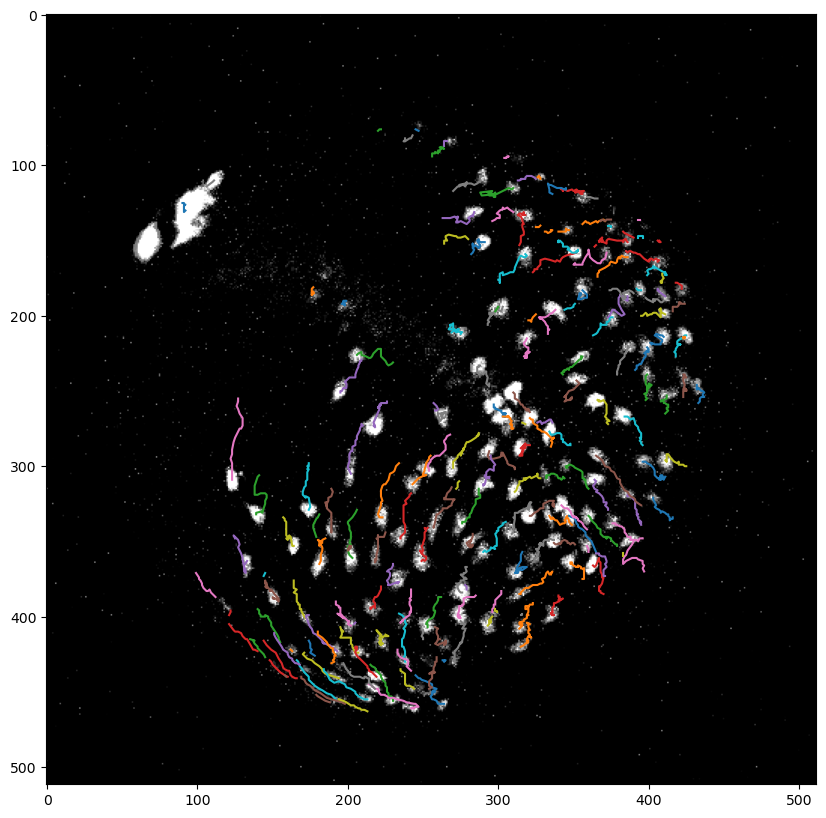

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(image_time[0].max(axis = 0))
for particle_id in range(tracks['particle'].max()):
    plt.plot(tracks[tracks.particle==particle_id].y,tracks[tracks.particle==particle_id].x,'-')
plt.show()

We can finally prune tracks that are too short by doing:

In [17]:
tracks_clean = trackpy.filter_stubs(tracks, threshold=15)

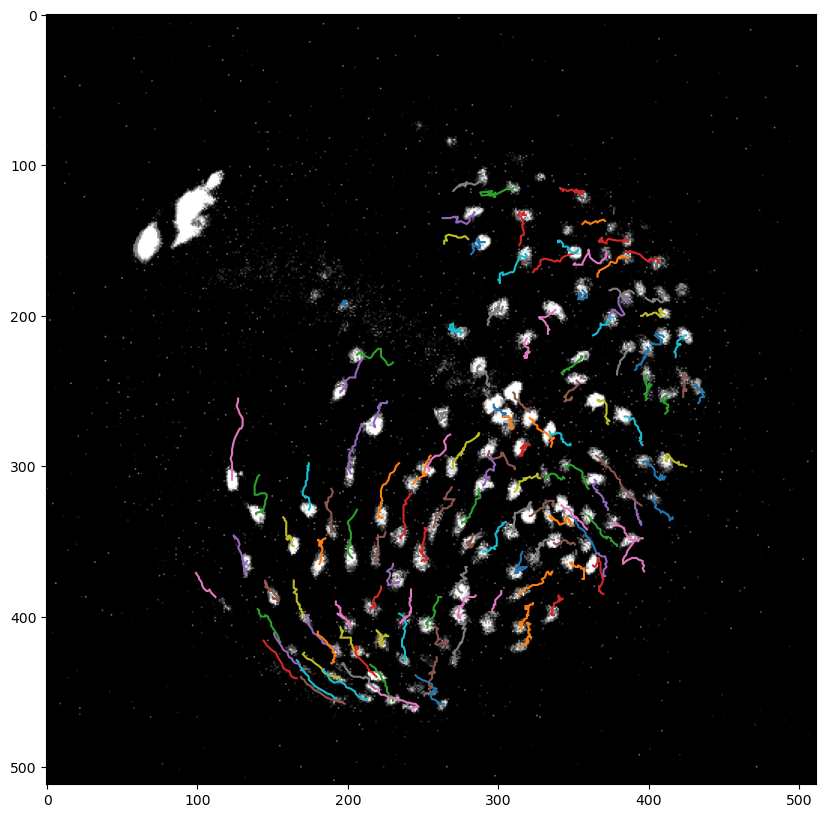

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(image_time[0].max(axis = 0))
for particle_id in range(tracks_clean['particle'].max()):
    plt.plot(tracks_clean[tracks_clean.particle==particle_id].y,
             tracks_clean[tracks_clean.particle==particle_id].x,'-')
plt.show()

## 11.2 Visualization

Until now we have only looked at projections. Instead we could look at single planes, and use e.g. ipywidgets to create sliders to move through space and time (as in Fiji), as presented in [03-Image_import.ipynb](03-Image_import.ipynb). However we might want to directly look at the 3D data. We are going to explore two solutions for this: ipyvolume and napari.

ipyvolume integrates well with notebook technology because it exploits pure web-technology as well. It's easy to do basic plotting in ipyvolume however customization of the rendering is not entirely trivial. In contrast, napari is based on tools meant to run locally on a computer. If you want to test it out, it will therefore only work if you made a local installation of this course. The very positive side of napari is its user-friendlyness that makes it very easy to create nice 3D rendering with little effort.

### 11.2.1 ipyvolume

We firsrt import the package:

In [19]:
import ipyvolume as ipv

Then we can create an ipyvolume figure and plot a volume:

In [20]:
ipv.figure()
ipv.volshow(image_time[0,:,:,:].astype(float))
ipv.show()

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.1, max=1.0, step…

By default we are given three levels of intensity to display. For each one we can set the "level" that should be shown, i.e. an intensity range around which to display colored voxels. By default, an isotropic box is displayed, independently of the range of dimensions. As the xy dimension is an order of magnitude large than the z dimension, the data appear distorted. We can fix that by specifying 1. the extent covered by the data, and 2. the range to display for each axis. If our data are isotropic (pixel-size == z-stack step) we should display the same range on all axes (e.g. 512) but specify that the z-stack only covers 44 planes. Note that to have the volume displayed in the center of the volume with set the z-axis to range from -range/2 to +range/2.

Other options can be specified when creating the figure, for example the levels of all colors and their opacities.

In [21]:
image_time.shape

(21, 44, 512, 512)

In [22]:
# set the actual spatial range of the data
xy_extent = [0,image_time.shape[2]]
z_extent = int(image_time.shape[1]/1)

ipv.figure()
volume_fig = ipv.volshow(image_time[0,:,:,:],extent=[xy_extent,xy_extent,[0,z_extent]],
            level=[0.3, 0.2,0.2], opacity = [10,0,0], controls=False)

# set the extent of the three axes
ipv.xyzlim(0, xy_extent[1])
ipv.zlim(-xy_extent[1]/2, xy_extent[1]/2)

ipv.show()



Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

Now we can plot on top of this the location of the detected nuclei using a ```scatter``` plot and the tracking traces using a simple line ```plot```.

In [23]:
# set the actual spatial range of the data
xy_extent = [0,image_time.shape[2]]
z_extent = int(image_time.shape[1]/1)

ipv_fig = ipv.figure()
volume_fig = ipv.volshow(image_time[-1,:,:,:],extent=[xy_extent,xy_extent,[0,z_extent]],
            level=[0.3, 0.2,0.2], opacity = [10,0,0], controls=False)

# add scatter plot
ipv.scatter(x = locmax[:,2].astype(float), y = locmax[:,1].astype(float), z = locmax[:,0].astype(float), size=1, color = 'blue')

# add lines of trajectories
for particle_id in np.unique(tracks_clean['particle']):
    ipv.plot(tracks_clean[tracks_clean.particle==particle_id].y.values,
             tracks_clean[tracks_clean.particle==particle_id].x.values,
             tracks_clean[tracks_clean.particle==particle_id].z.values)
    
# set the extent of the three axes
ipv.xyzlim(0, xy_extent[1])
ipv.zlim(-xy_extent[1]/4, xy_extent[1]/4)

ipv.show()




Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

As the rendering is purely web-based, we can now save our figure as an html object, that we could for example embed in a web-page:

In [24]:
ipv.save('interactive_figure.html')

We obtained relatively quickly a 3D representation of our data and and the interesting possibility to easily save a dynamic output. Also, virtually any detail of this plot can be customized and there are interesting possibilities to add interactivity via ipywidgets. However this customization requires some more advanced knowledge and understanding of the code of this tool. Hence it is probably not the best solution for beginners.

For the purpose of completeness and as a starting point for people who would like to explore more in depth this tool, we add here an example with some advanced features such as interactive controls.

In [25]:
from ipywidgets import ColorPicker, VBox, HBox, jslink, FloatSlider


# set the actual spatial range of the data
xy_extent = [0,image_time.shape[2]]
z_extent = int(image_time.shape[1]/1)

ipv_fig = ipv.figure()
volume_fig = ipv.volshow(image_time[0,:,:,:].astype(float),extent=[xy_extent,xy_extent,[0,z_extent]],
            level=[0.3, 0.2,0.2], opacity = [10,0,0], controls=False)

# add scatter plot
detect_fig = ipv.scatter(x = locmax[:,2].astype(float), y = locmax[:,1].astype(float), z = locmax[:,0].astype(float), size=1, color = 'blue')

# set the extent of the three axes
ipv.xyzlim(0, xy_extent[1])
ipv.zlim(-xy_extent[1]/4, xy_extent[1]/4)

# add lines of trajectories
for particle_id in np.unique(tracks_clean['particle']):
    ipv.plot(tracks_clean[tracks_clean.particle==particle_id].y.values,
             tracks_clean[tracks_clean.particle==particle_id].x.values,
             tracks_clean[tracks_clean.particle==particle_id].z.values)

# change background color
ipv.style.background_color('black')

# create a color picker anad link it to the color features
# of the detection plot
color = ColorPicker(description = 'Segmentation color')
jslink((detect_fig, 'color'), (color, 'value'))
# create a brightness control
brightness_data = FloatSlider(min=0, max=100,value = 7.0, description = 'brightness')
jslink((volume_fig, 'brightness'), (brightness_data, 'value'))


ipv.show()
# display control
HBox([color, brightness_data])


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [26]:
ipv.save('interactive_figure.html')

### 11.2.2 napari

A very interesting alternative for 3D plotting is napari. It is a very recent software but it has been already widely adopted as it offers a powerful combination of features making it useful in a wide variety of cases. Also, in contrast to ipyvolume, adjusting the rendering, browsing through data etc. is much more intuitive. As previously mentioned, the only drawback is the impossibility to use it remotely, so this section is only executable is you run the notebook on your own computer.

First we import napari:

In [28]:
import napari
from napari.utils import nbscreenshot

napari offers first the possbility to quickly plot all sorts of data (scatter plots, surfaces, labels etc), in particular volume  data:

In [31]:
viewer = napari.view_image(image_time, colormap='green');

This will generate the following type of window:

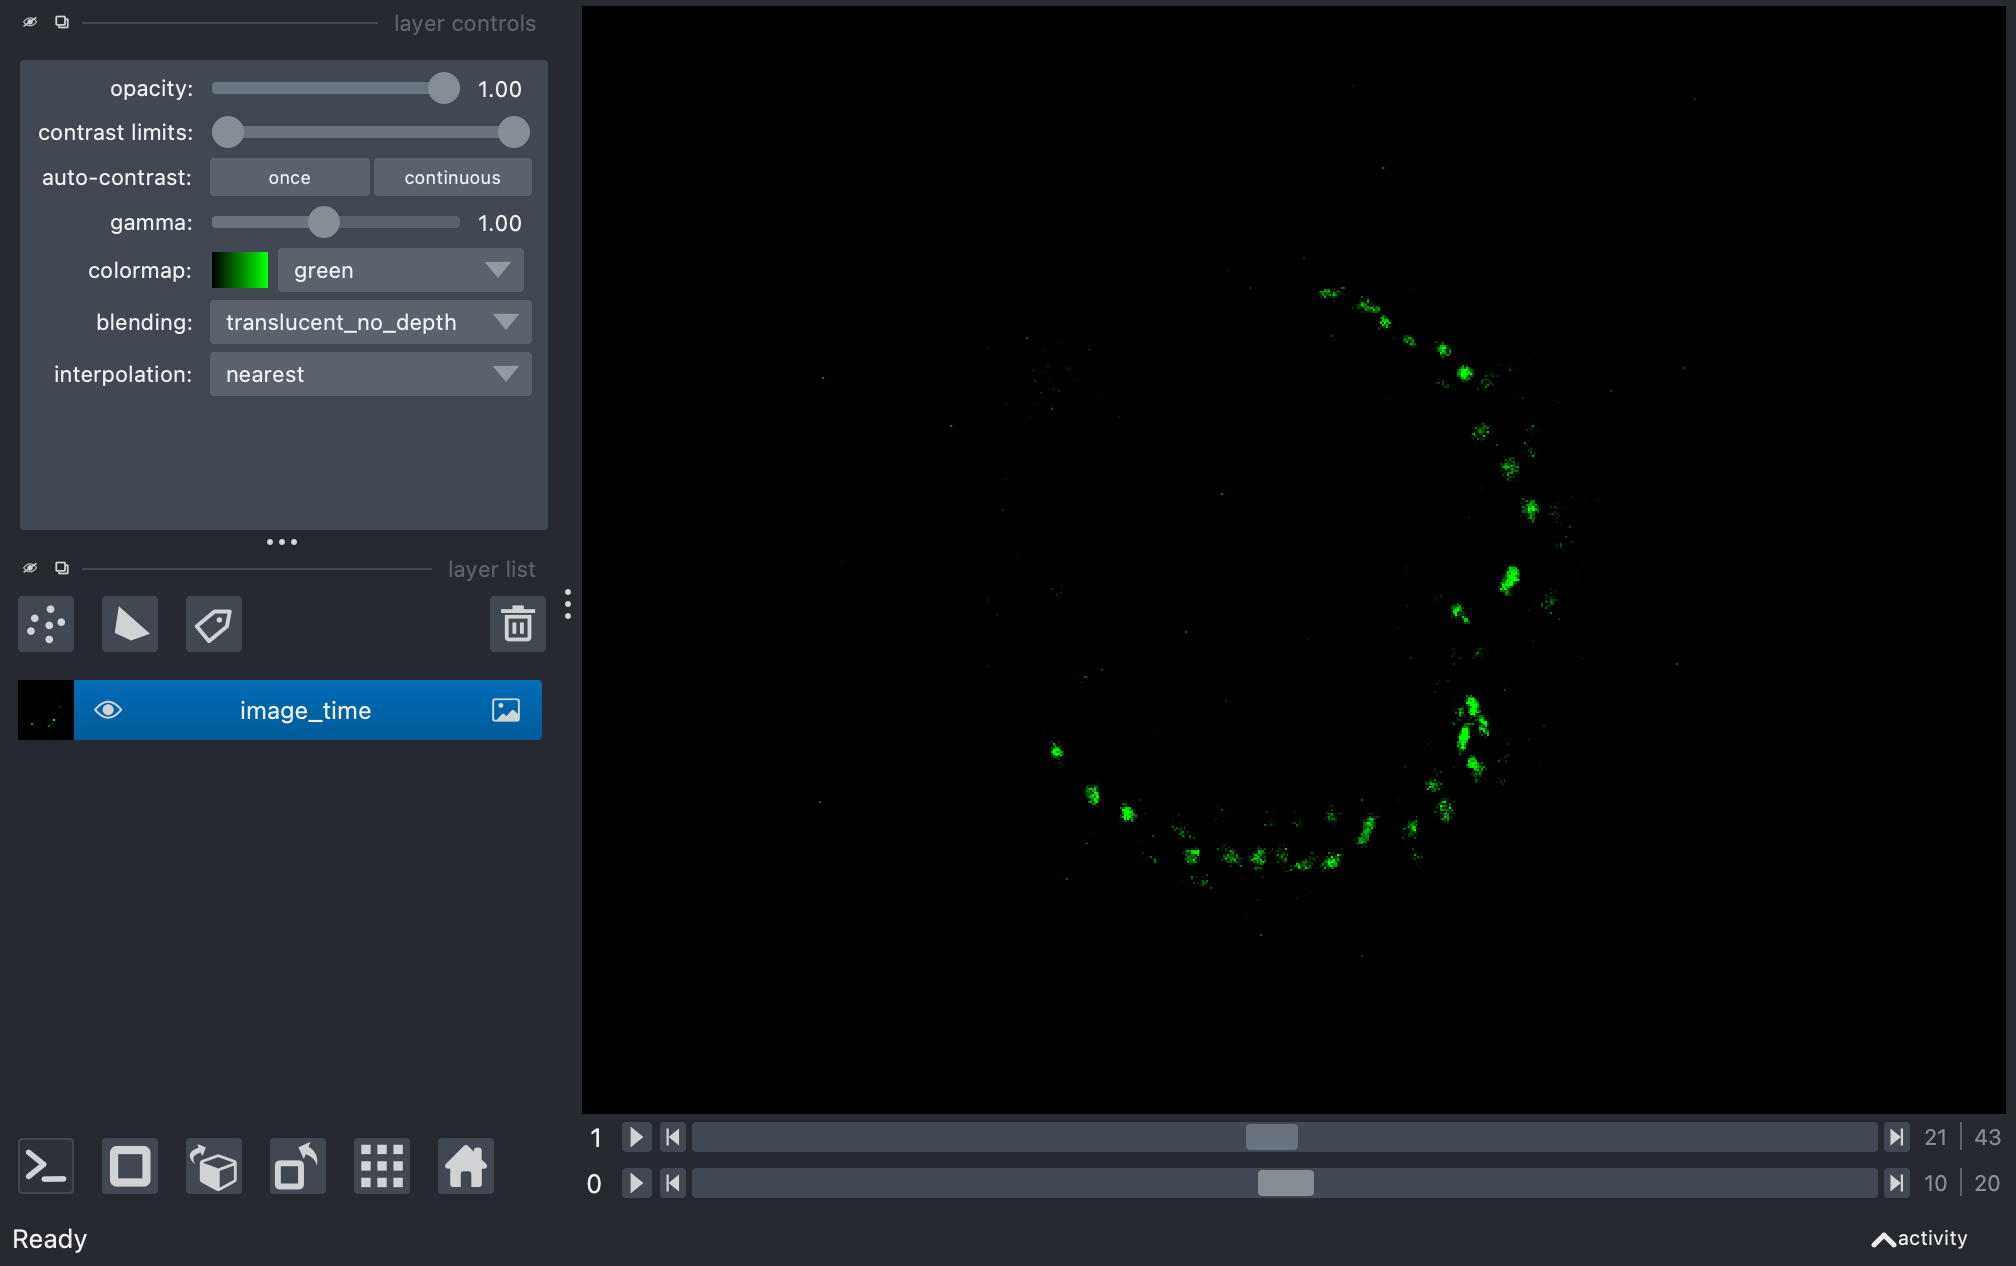

In [32]:
nbscreenshot(viewer)

Sliders to scroll through the different dimensions are created automatically. The icons on the lower-left allow one to switch the types of view (stack, 3D, projection axis etc.) and command on the top-left allow to customize the rendering. In the middle we see a panel named "Image" which corresponds to our plotted image. Just like we can add multiple plots on top of each other in matplotlib, we can do the same in napari. This requires to first create a viewer and then sequentially add the data. We add here the complete xyzt image stack as well as the tracks.

First we create a list of xyz coordinates of all the tracks:

In [33]:
track_list = [tracks_clean[tracks_clean.particle==particle_id][['z','x','y']].values
 for particle_id in np.unique(tracks_clean['particle'])]

Then we ```add_image``` for the image, we ```add_points``` for the locations of all the nuclei across time, and finally we ```add_shapes``` to add lines corresponding to the tracks.

In [40]:
viewer = napari.Viewer()
viewer.add_image(image_time, colormap = 'green')
viewer.add_points(assembled[:,[3,0,1,2]], face_color = 'blue', opacity = 0.5, size = 5)
viewer.add_shapes(track_list, shape_type='path', edge_color='red');
viewer.dims.ndisplay=3

/Users/gw18g940/mambaforge/envs/biapy2/lib/python3.10/site-packages/vispy/visuals/tube.py:136: RuntimeWarning: invalid value encountered in divide
  tangents /= mags[:, np.newaxis]


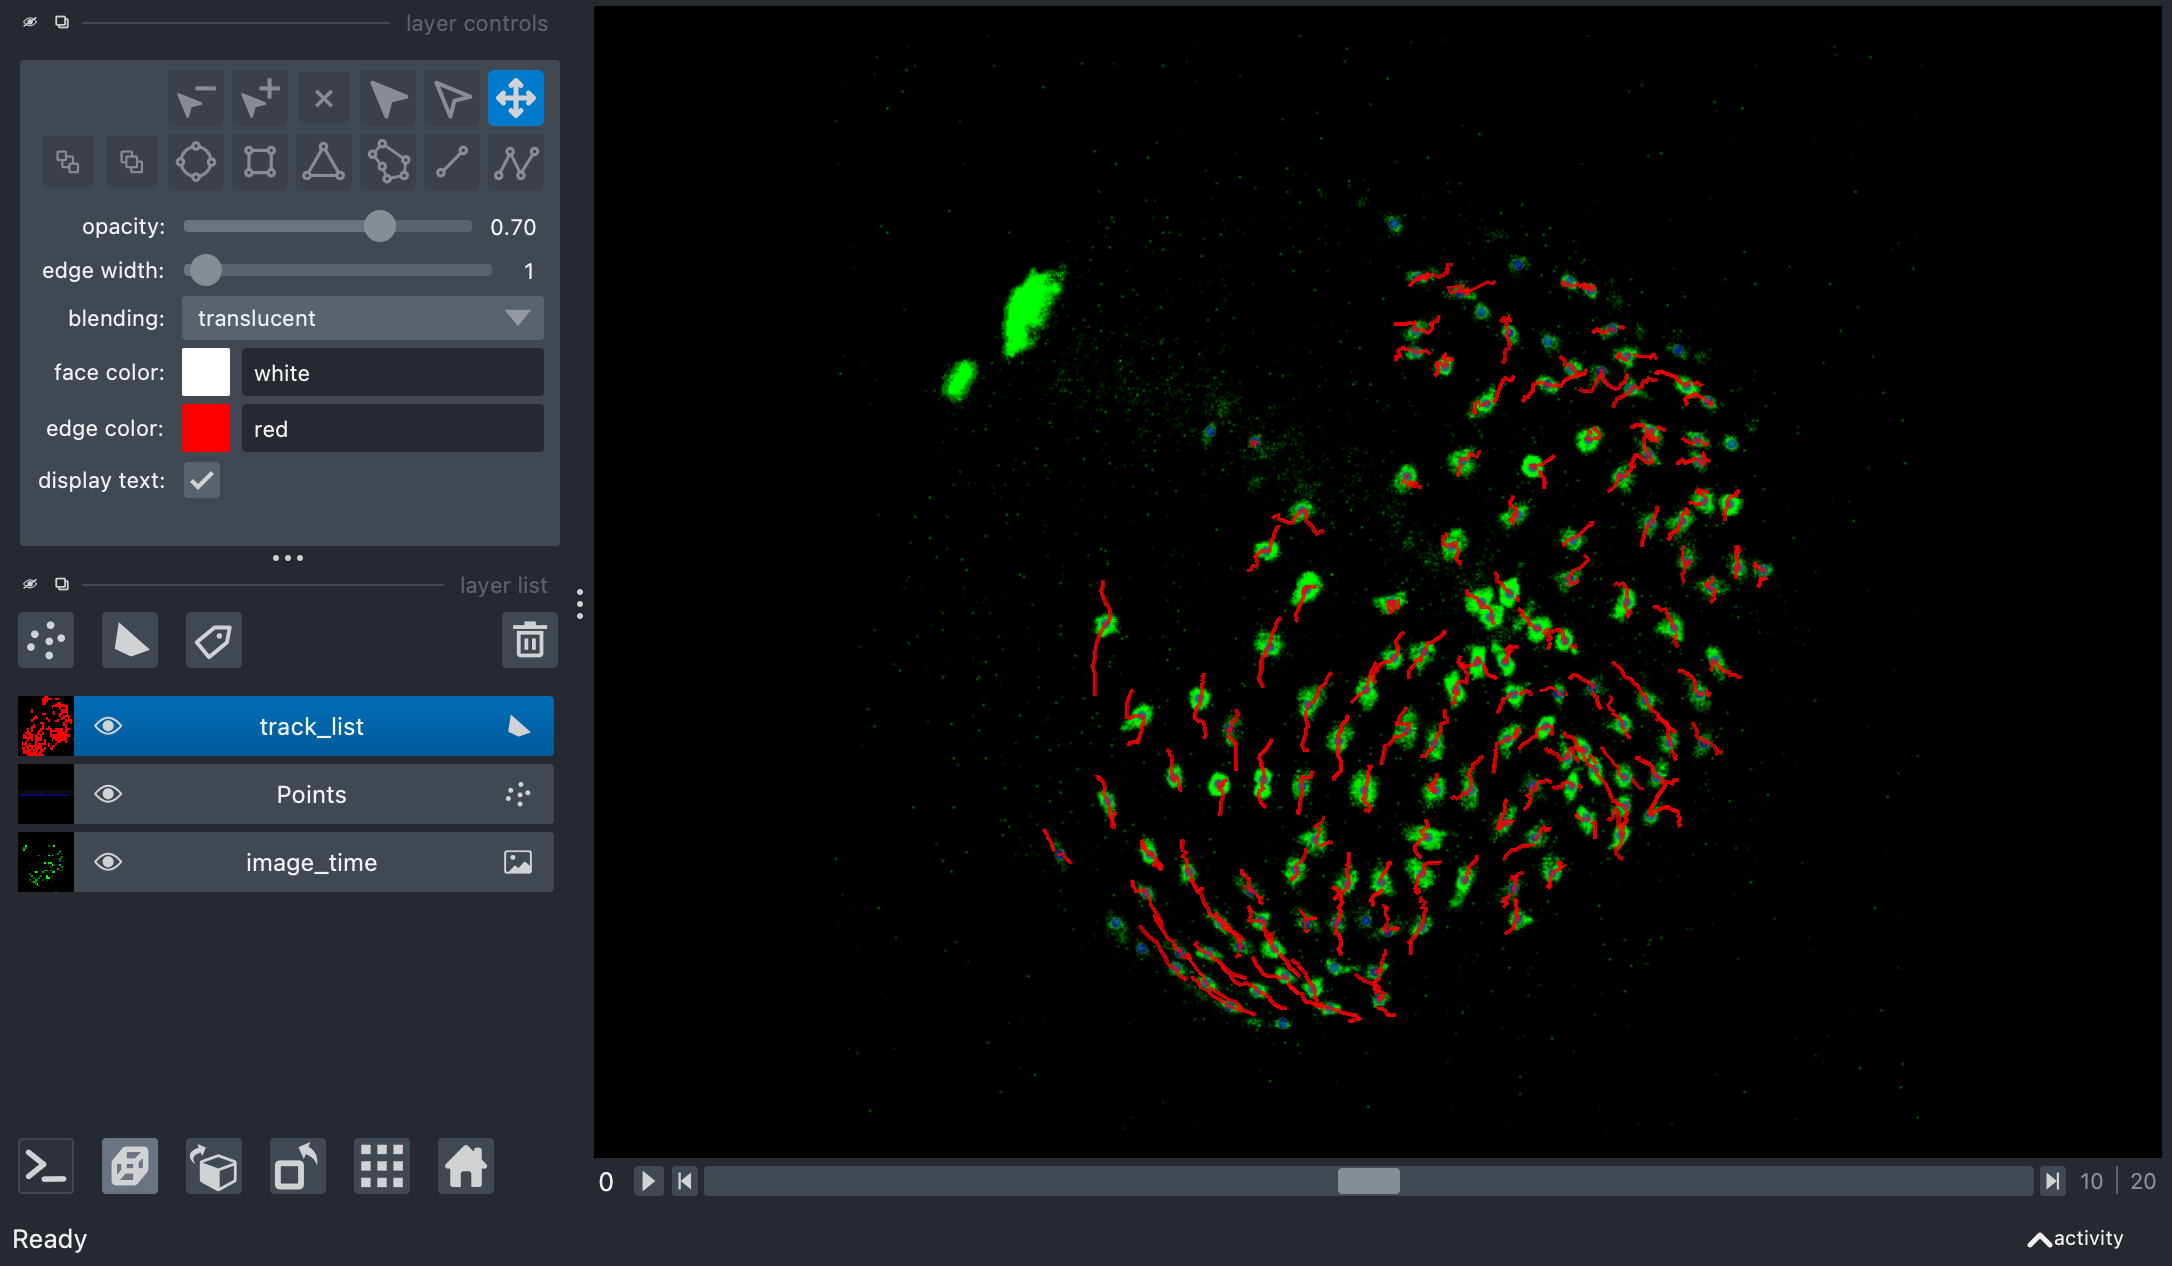

In [41]:
nbscreenshot(viewer)

Finally we can grab a screen capture of the image to create an illustration or even create a movie using the [napari-animation plugin](https://github.com/napari/napari-animation).

In [42]:
viewer.screenshot('myimage.png');